# My lab 运用不同算子提取车牌的边缘（sobel算子，Prewitt算子，Laplacian算子）
步骤与Lab2相同



sobel_kernel dx: {-1,0,1;-2,0,2;-1,0,1}  dy:{-1,-2,-1;0,0,0;1,2,1}

Prewitt_kernel dx:{-1,-1,-1,0,0,0,1,1,1} dy:{-1,0,1;-1,0,1;-1,0,1}

Laplacian_kernel H={0,-1,0;-1,4,-1;0,-1,0}


不同边缘提取算子的区别：

1、sobel算子：Sobel算子根据像素点上下、左右邻点灰度加权差，在边缘处达到极值这一现象检测边缘。
             对噪声具有平滑作用，提供较为精确的边缘方向信息。obel算子的边缘定位更准确，常用于
             噪声较多、灰度渐变的图像。

2、Prewitt算子：Prewitt算子是一种图像边缘检测的微分算子，其原理是利用特定区域内像素灰度值产生
               的差分实现边缘检测。Prewitt算子适合用来识别噪声较多、灰度渐变的图像，

3、Laplacian算子：拉普拉斯(Laplacian) 算子是 n维欧几里德空间中的一个二阶微分算子，常用于图像
                 增强领域和边缘提取。它通过灰度差分计算邻域内的像素。


！！！！
TIPS:到了后面有点错误，没时间修正，会在提交后继续修改

！！！！


我们首先导入OpenCV-Python库用作图像处理（Sobel），matplotlib库用作绘图。

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

我们可以通过`imread`方法读取jpg格式的图片，原图是车牌照片

In [3]:
img = cv2.imread("./chepai.png")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(241, 321, 3)


通过`imshow`方法进行图片显示。

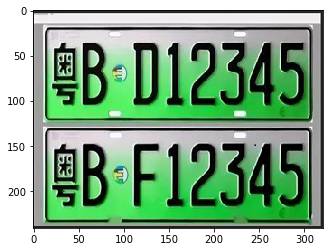

In [4]:
plt.imshow(img[:,:,::-1])

### RGB图转灰度图
将RGB图像转为灰度图，我们可以直观的看到数据维度的变化。

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("灰度图尺寸：{}".format(gray.shape))

灰度图尺寸：(241, 321)


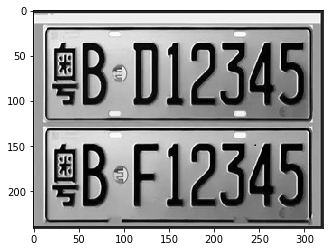

In [6]:
plt.imshow(gray,cmap='gray')

### 使用Sobel算子提取边缘
我们可以使用`Sobel`方法对图像提取边缘，最后两个参数表示导数x与y的阶数。
- `sobel_x`与`sobel_y`为横向与纵向上的边缘检测结果
- `sobel_res`为两者相加得到的梯度，并在0-255之间截断，即我们得到的结果

In [7]:
import time

start_time = time.time()

sobel_x =cv2.Sobel(gray,cv2.CV_8U ,1,0)
sobel_y = cv2.Sobel(gray,cv2.CV_8U ,0,1)
sobel_res = np.clip(sobel_x + sobel_y, 0, 255)

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.022728443145751953s


绘制上述三幅图像。

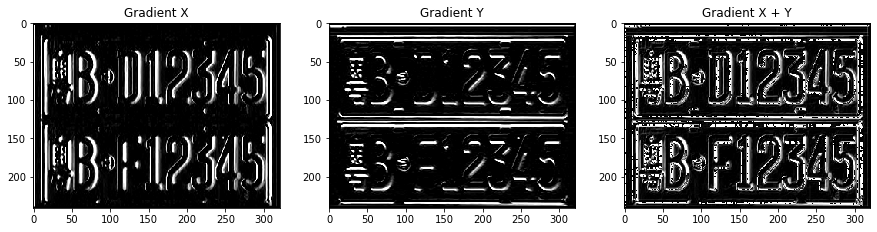

In [8]:
fig_sobel3 = plt.figure()
fig_sobel3.set_figheight(4)
fig_sobel3.set_figwidth(15)
# gradient x
fig_1 = fig_sobel3.add_subplot(131)
fig_1.title.set_text('Gradient X')
plt.imshow(sobel_x,cmap='gray')
# gradient y
fig_2 = fig_sobel3.add_subplot(132)
fig_2.title.set_text('Gradient Y')
plt.imshow(sobel_y,cmap='gray')
# gradient
fig_3 = fig_sobel3.add_subplot(133)
fig_3.title.set_text('Gradient X + Y')
plt.imshow(sobel_res,cmap='gray')

# 02:  Hardware Sobel
## 方式1：直接调用
我们会在方式1中展示类似Lab1的直接调用方式，在方式2中将通过创建Driver来构建一个用户友好的API。
### 载入Overlay

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [9]:
from pynq import Overlay, allocate

overlay = Overlay("./Laplacion_edge_detection.bit")

Laplacion_edge_detection = overlay.Laplacian_edge_detec_0

In [10]:
# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

### 写入参数
在IP上写入值时，我们可以像Lab1一样根据HLS给出的IP Driver Source Code直接在对应位置写入：

In [11]:
Laplacion_edge_detection.write(0x10, rows)
Laplacion_edge_detection.write(0x18, cols)

由于提供了`Sobel.hwh`文件，`sobel`对象已经包含了Register Map并将其暴露出来，我们可以直接打印查看各寄存器的信息：

In [12]:
Laplacion_edge_detection.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, RESERVED_3=0, RESERVED_4=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0, CHAN2_INT_EN=0, RESERVED_1=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0, CHAN2_INT_ST=0, RESERVED_1=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

我们也可以直接在Register Map中与其交互，而不需要去手动输入对应的地址：

In [13]:
Laplacion_edge_detection.register_map.rows = rows
Laplacion_edge_detection.register_map.cols = cols

### 启动IP

将IP中的DMA对象提取出来。

In [14]:
dma = overlay.axi_dma_0

Sobel IP 使用了AXI Stream的接口格式。
- 我们需要调用DMA读取输入缓冲，并将数据发送到AXI Stream Master
- 之后，DMA应从AXI Stream Slave中将结果写回到输出缓冲中
- `wait`语句确保了DMA的处理操作已经完成

In [15]:
import time

Laplacion_edge_detection.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

KeyboardInterrupt: 

将结果进行可视化。

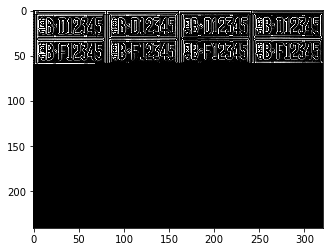

In [16]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')

## 方式2：为IP创建一个Driver
创建一个用户有好的API将是我们的下一步，我们希望可以创建一个对于特定IP的驱动程序。
- 公开单个的`sobel3x3`函数来调用加速器
- 继承pynq的`DeafaultIP`

In [17]:
from pynq import DefaultIP

class SobelDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)

    bindto = ['xilinx.com:hls:Laplacion_edge_detection:1.0']

    def sobel3x3(self, imgi, imgo, rows, cols):      
        
        self.write(0x10, rows)
        self.write(0x18, cols)
        self.register_map.CTRL.AP_START = 1
        
        dma.sendchannel.transfer(imgi)
        dma.recvchannel.transfer(imgo)
        dma.sendchannel.wait() # wait for send channel
        dma.recvchannel.wait() # wait for recv channel
        
        res = imgo.reshape(rows, cols)
        return res

重新载入Overlay使得更改生效：

In [18]:
overlay = Overlay("./Laplacion_edge_detection.bit")
dma = overlay.axi_dma_0
Laplacion_edge_detection =overlay.Laplacian_edge_detec_0

现在，我们可以直接调用上方描述的`sobel3x3`方法：

In [19]:
res = Laplacion_edge_detection.sobel3x3(input_buffer, output_buffer, rows, cols)

AttributeError: 'DefaultIP' object has no attribute 'sobel3x3'

In [20]:
plt.imshow(res,cmap='gray')

NameError: name 'res' is not defined